In [6]:
import torch

# Check if CUDA (GPU support) is available
from pytorch_tabnet.tab_model import TabNetRegressor

# Set the device name based on CUDA availability
model = TabNetRegressor(device_name='cpu')  # Use 'cuda' if you have a GPU and CUDA set up


# model = TabNetRegressor().to(device)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

import os
import wget
from pathlib import Path

# Download census-income dataset

In [7]:
data_one = pd.read_csv("data/2000to2012.csv")
data_two = pd.read_csv("data/2012to2014.csv")
data_three = pd.read_csv("data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/jan2017upwards.csv")

data_one = data_one.drop(columns=["block", "street_name"])
data_two = data_two.drop(columns=["block", "street_name"])
data_three = data_three.drop(columns=["block", "street_name"])
data_four = data_four.drop(columns=["block", "street_name"])

combined_data = pd.concat([data_one, data_two, data_three, data_four], ignore_index=True)

sorted_combined_data = combined_data.sort_values(by='month', ascending=True)

sorted_combined_data['remaining_lease'] = sorted_combined_data['remaining_lease'].fillna('NULL')

sorted_combined_data

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0,NULL
1588,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,66.0,Improved,1970,145000.0,NULL
1589,2000-01,QUEENSTOWN,3 ROOM,16 TO 18,72.0,Improved,1970,208000.0,NULL
1590,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,72.0,Improved,1970,186000.0,NULL
1591,2000-01,QUEENSTOWN,3 ROOM,01 TO 03,72.0,Improved,1970,182000.0,NULL
...,...,...,...,...,...,...,...,...,...
633288,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A,1990,538888.0,65 years 02 months
633289,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation,1985,538000.0,60 years 05 months
633290,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation,1978,538000.0,53 years 03 months
633276,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A,2019,573000.0,94 years 07 months


In [8]:
CPIData = pd.read_csv('data\PercentChangeInConsumerPriceIndexCPIOverPreviousPeriod2019AsBaseYearMonthly.csv', header=None)
datetoextract = CPIData.iloc[0]
indextoextract = CPIData.iloc[67]
data = {'Period': datetoextract, 'CPIvalue': indextoextract}
AccomsCPI = pd.DataFrame(data)
AccomsCPI = AccomsCPI.drop(AccomsCPI.index[0])

AccomsCPI[['Year', 'Month']] = AccomsCPI['Period'].str.extract('(\d{4})(\w{3})', expand=True)
AccomsCPI['Date'] = pd.to_datetime(AccomsCPI['Year'] + AccomsCPI['Month'], format='%Y%b')
AccomsCPI = AccomsCPI.sort_values(['Year', 'Date'], ascending=[False, False])
AccomsCPI = AccomsCPI[AccomsCPI['Date'] >= '2000-01-01']
AccomsCPI = AccomsCPI.drop(['Year', 'Month', 'Date'], axis=1)
AccomsCPI.loc[AccomsCPI['CPIvalue'] == 'na', 'CPIvalue'] = 0
AccomsCPI = AccomsCPI.reset_index(drop=True)
AccomsCPI['CPIvalue'] = AccomsCPI['CPIvalue'].astype(float)
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y%b')
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)
AccomsCPI.dtypes

Period       object
CPIvalue    float64
dtype: object

In [9]:
AccomsCPI['AdjustmentValue'] = 1.0

# Loop to calculate AdjustmentValue
for idx, cpi in enumerate(AccomsCPI['CPIvalue']):
    if idx != 0:
        AccomsCPI.loc[idx, 'AdjustmentValue'] = AccomsCPI.loc[idx - 1, 'AdjustmentValue'] * (1 + (AccomsCPI.loc[idx - 1, 'CPIvalue'] / 100))

# Corrected datetime conversion
AccomsCPI['Period'] = pd.to_datetime(AccomsCPI['Period'], format='%Y-%m')

# Converting to Period type
AccomsCPI['Period'] = AccomsCPI['Period'].dt.to_period('M')

# Converting Period to string
AccomsCPI['Period'] = AccomsCPI['Period'].astype(str)

# Printing the DataFrame to check the results
print(AccomsCPI)

      Period  CPIvalue  AdjustmentValue
0    2024-01      -2.7         1.000000
1    2023-12       0.2         0.973000
2    2023-11       1.9         0.974946
3    2023-10      -1.4         0.993470
4    2023-09       0.3         0.979561
..       ...       ...              ...
284  2000-05       0.0         1.450914
285  2000-04       0.0         1.450914
286  2000-03       0.0         1.450914
287  2000-02       0.0         1.450914
288  2000-01       0.0         1.450914

[289 rows x 3 columns]


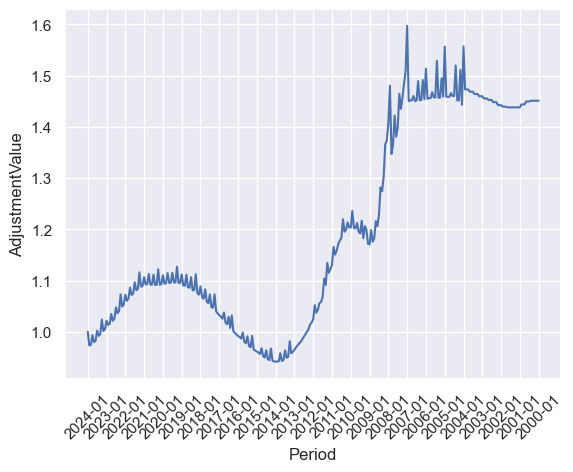

In [10]:
ax = sb.lineplot(data=AccomsCPI, x='Period', y='AdjustmentValue' )
ax.set_xticks(range(0, len(AccomsCPI), 12))  
ax.set_xticklabels([AccomsCPI['Period'][i] for i in range(0, len(AccomsCPI), 12)], rotation=45) 


plt.show()

In [11]:
merged_data = pd.merge(sorted_combined_data, AccomsCPI, left_on='month', right_on='Period', how='left')

# Fill missing AdjustmentValue with 1.0
merged_data['AdjustmentValue'] = merged_data['AdjustmentValue'].fillna(1.0)

# Adjust the sale price to today's cost
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue']

# Drop the unnecessary columns after adjustment
columns_to_drop = ['Period', 'CPIvalue']
merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns], axis=1, inplace=True)

#changing "x" years and "y" months into x+(y/12) years ---> eg 4years 6 months = 4.5years 
merged_data['years'] = merged_data['remaining_lease'].str.extract(r'(\d+) years').astype(float)
merged_data['months'] = merged_data['remaining_lease'].str.extract(r'(\d+) months').astype(float)
merged_data['remaining_lease'] = merged_data['years'] + merged_data['months'] / 12
merged_data = merged_data.drop(['years', 'months'], axis=1)

#changing 7 to 9 floor into average of 8th floor
merged_data['lower_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,0]
merged_data['upper_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2
columns_to_drop_final = ['lower_storey', 'upper_storey', 'storey_range', 'resale_price', 'AdjustmentValue']
merged_data = merged_data.drop(columns=[col for col in columns_to_drop_final if col in merged_data.columns], axis=1)

merged_data['remaining_lease'] = merged_data['remaining_lease'].fillna(np.nan)

merged_data.dtypes




month                     object
town                      object
flat_type                 object
floor_area_sqm           float64
flat_model                object
lease_commence_date        int64
remaining_lease          float64
resale_price_adjusted    float64
average_storey           float64
dtype: object

Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.6144291610822235
Mean Squared Error (MSE): 12171037222.915293

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6149428407899642
Mean Squared Error (MSE): 11984700806.214554



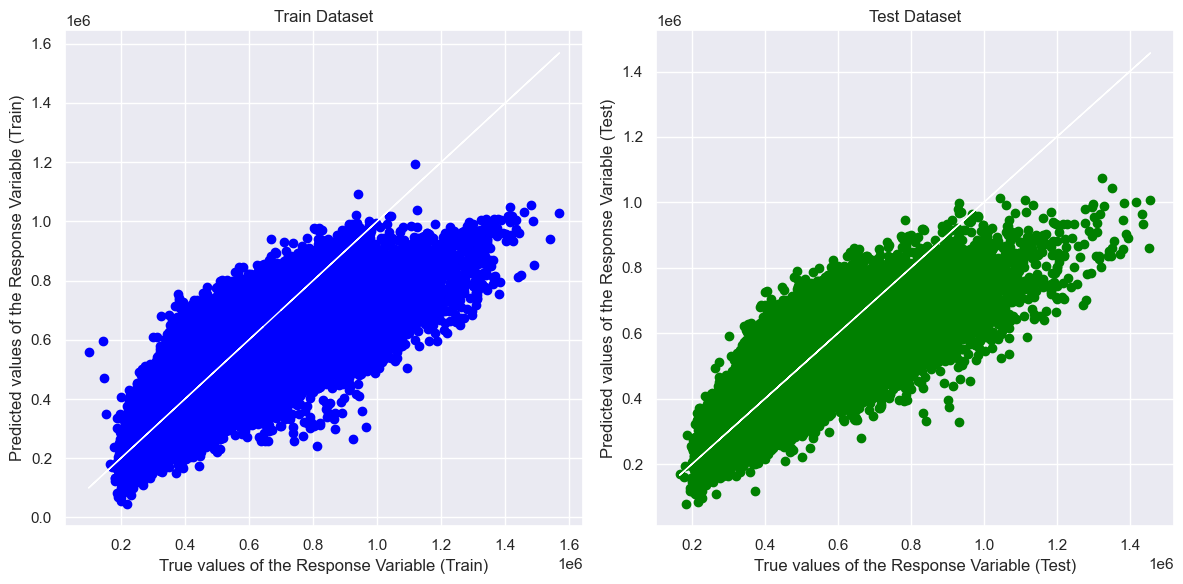

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

numericalData = pd.DataFrame(merged_data[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey', 'resale_price_adjusted']])

# Drop NaN values from both features and target variable
numericalData.dropna(subset=['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey', 'resale_price_adjusted'], inplace=True)
X = numericalData[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey']]
y = numericalData['resale_price_adjusted']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model Evaluation
print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color="blue")
plt.plot(y_train, y_train, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color="green")
plt.plot(y_test, y_test, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [13]:
numericalData.corr()


,floor_area_sqm,lease_commence_date,remaining_lease,average_storey,resale_price_adjusted
floor_area_sqm,1.000000,0.116295,0.123232,-0.012596,0.621662
lease_commence_date,0.116295,1.000000,0.989363,0.275722,0.363799
remaining_lease,0.123232,0.989363,1.000000,0.275259,0.333760
average_storey,-0.012596,0.275722,0.275259,1.000000,0.368067
resale_price_adjusted,0.621662,0.363799,0.333760,0.368067,1.000000


<Axes: >

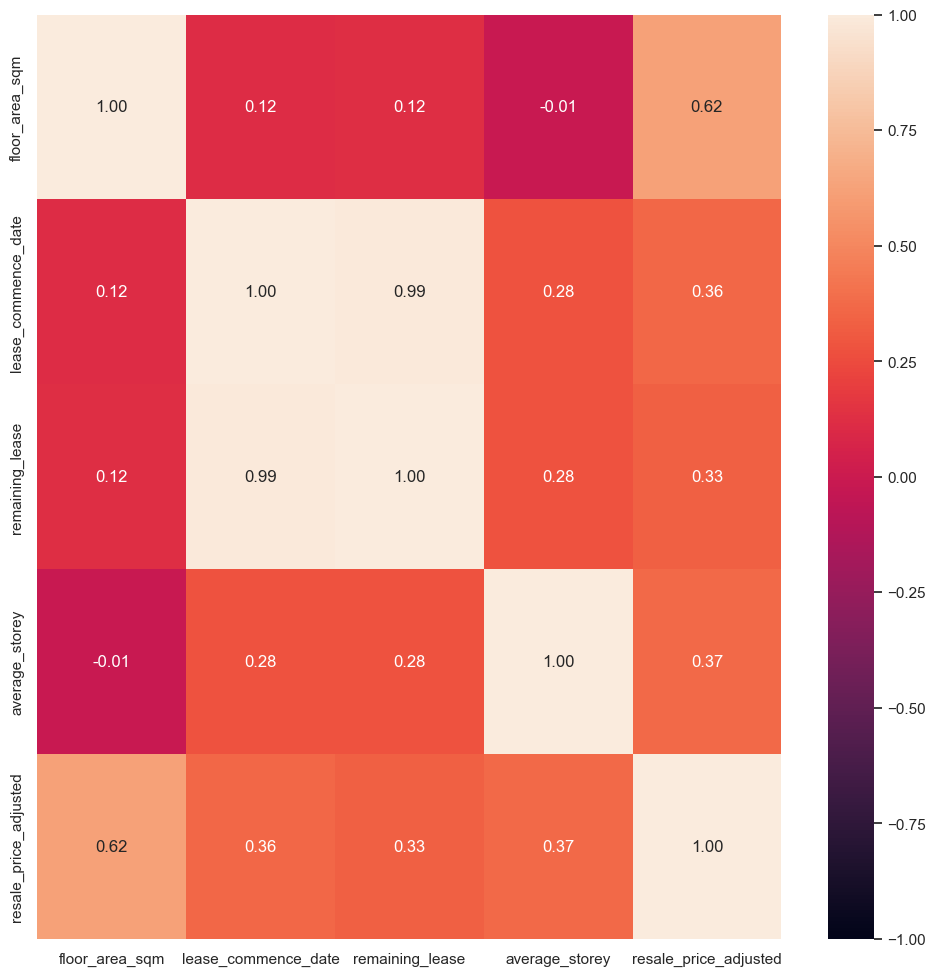

In [14]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(numericalData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")


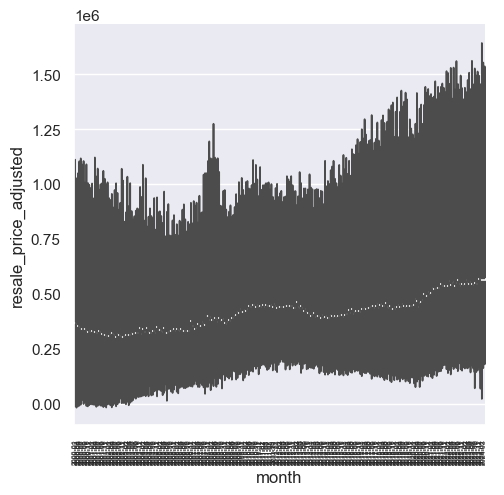

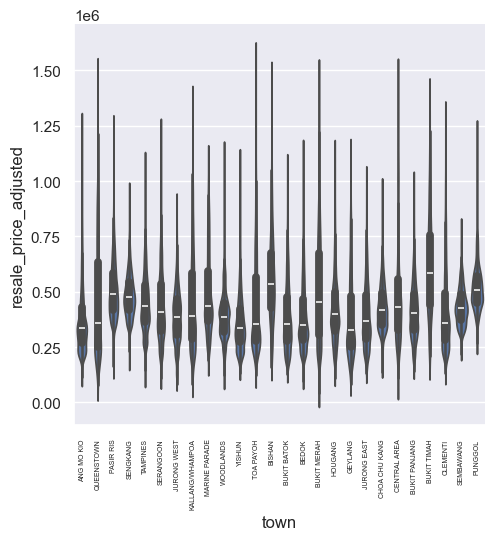

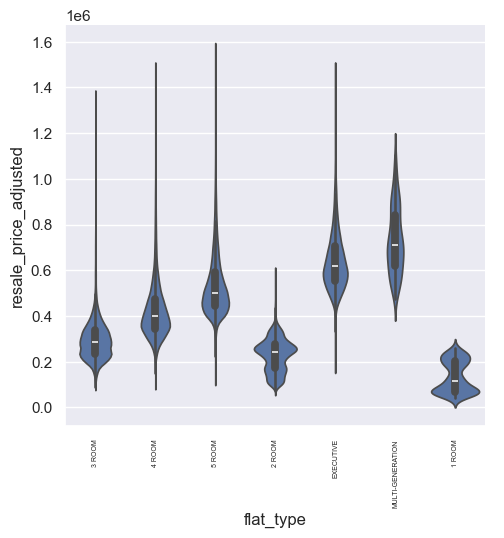

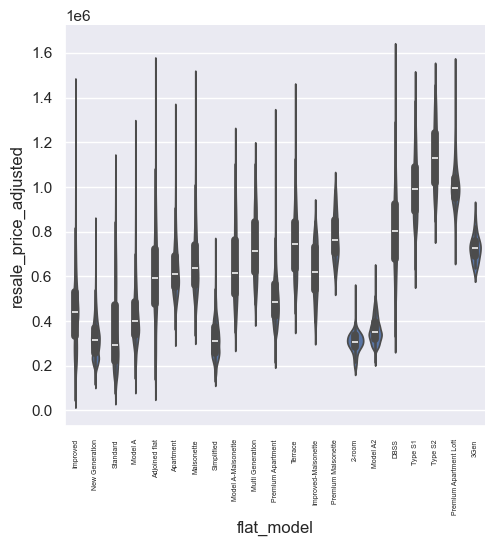

In [15]:
categoricaldata = pd.DataFrame(merged_data[['month', 'town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['month', 'town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'violin')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


In [16]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634002 entries, 0 to 634001
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   month                  634002 non-null  object 
 1   town                   634002 non-null  object 
 2   flat_type              634002 non-null  object 
 3   floor_area_sqm         634002 non-null  float64
 4   flat_model             634002 non-null  object 
 5   lease_commence_date    634002 non-null  int64  
 6   remaining_lease        146368 non-null  float64
 7   resale_price_adjusted  634002 non-null  float64
 8   average_storey         634002 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 43.5+ MB


# Load data and split

In [17]:
train = merged_data
target = 'resale_price_adjusted'

# If the 'Set' column does not exist, create it to randomly assign rows to train, valid, and test sets.
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

# Get indices for each set.
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [18]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'train' is your DataFrame.

# Initialize lists and dictionaries.
categorical_columns = []
categorical_dims = {}

# Process categorical columns.
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    # Fill missing values with a placeholder string, 'VV_likely'.
    train[col] = train[col].fillna("VV_likely")
    # Transform the column with LabelEncoder.
    train[col] = l_enc.fit_transform(train[col].values)
    # Append the column name to the list of categorical columns.
    categorical_columns.append(col)
    # Store the number of unique values in the categorical_dims dictionary.
    categorical_dims[col] = len(l_enc.classes_)

# Process numerical columns.
# Note: You should only fill NaNs with the mean of the training set to prevent data leakage.
for col in train.columns[(train.dtypes == 'float64') | (train.dtypes == 'int64')]:
    # Calculate the mean from the training set only.
    mean_value = train.loc[train_indices, col].mean()
    # Fill missing values with the mean value.
    train.fillna({col: mean_value}, inplace=True)

# If 'remaining_lease' has NaNs, this is a special case because it's a float but with a lot of missing values.
# You might want to fill its NaNs separately with the mean or another relevant statistic from the training set.
if 'remaining_lease' in train.columns:
    mean_remaining_lease = train.loc[train_indices, 'remaining_lease'].mean()
    train.fillna({'remaining_lease': mean_remaining_lease}, inplace=True)

train


month 291
town 26
flat_type 7
flat_model 21
Set 3


,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price_adjusted,average_storey,Set
0,0,0,2,69.0,5,1986,74.629037,213284.384458,8.0,1
1,0,18,2,66.0,5,1970,74.629037,210382.556098,5.0,1
2,0,18,2,72.0,5,1970,74.629037,301790.149437,17.0,1
3,0,18,2,72.0,5,1970,74.629037,269870.037477,5.0,1
4,0,18,2,72.0,5,1970,74.629037,264066.380757,2.0,1
...,...,...,...,...,...,...,...,...,...,...
633997,290,11,3,105.0,8,1990,65.166667,538888.000000,2.0,1
633998,290,11,3,91.0,12,1985,60.416667,538000.000000,11.0,1
633999,290,11,3,98.0,12,1978,53.250000,538000.000000,8.0,1
634000,290,11,3,92.0,8,2019,94.583333,573000.000000,5.0,1


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634002 entries, 0 to 634001
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   month                  634002 non-null  int32  
 1   town                   634002 non-null  int32  
 2   flat_type              634002 non-null  int32  
 3   floor_area_sqm         634002 non-null  float64
 4   flat_model             634002 non-null  int32  
 5   lease_commence_date    634002 non-null  int64  
 6   remaining_lease        634002 non-null  float64
 7   resale_price_adjusted  634002 non-null  float64
 8   average_storey         634002 non-null  float64
 9   Set                    634002 non-null  int32  
dtypes: float64(4), int32(5), int64(1)
memory usage: 36.3 MB


# Define categorical features for categorical embeddings

In [20]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Define your embedding sizes for categorical features. This could be based on the cardinality of the features
# or determined through experimentation. For example, a common heuristic is to take the 
# min(50, (category_count + 1) // 2), but here we just use predefined sizes.
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]


# Network parameters

In [21]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [22]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [30]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [31]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [32]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 203172835824.20465| train_rmsle: 5.38209 | train_mae: 421699.7527| train_rmse: 449671.05643| train_mse: 202204058987.6923| valid_rmsle: 5.36982 | valid_mae: 421595.19487| valid_rmse: 449404.67576| valid_mse: 201964562599.3936|  0:01:25s
epoch 1  | loss: 193282019949.3644| train_rmsle: 5.06129 | train_mae: 407006.44668| train_rmse: 432539.25807| train_mse: 187090209770.45987| valid_rmsle: 5.02648 | valid_mae: 406860.27841| valid_rmse: 432251.3867| valid_mse: 186841261302.85403|  0:02:41s
epoch 2  | loss: 176048514434.89987| train_rmsle: 5.58139 | train_mae: 386635.25472| train_rmse: 410223.56565| train_mse: 168283373817.5092| valid_rmsle: 5.56284 | valid_mae: 386475.07988| valid_rmse: 409925.7169| valid_mse: 168039093372.20456|  0:04:11s
epoch 3  | loss: 154473610528.4513| train_rmsle: 5.62365 | train_mae: 354585.22748| train_rmse: 374334.54188| train_mse: 140126349246.09366| valid_rmsle: 5.59607 | valid_mae: 354347.35931| valid_rmse: 373984.67925| valid_mse: 1398645403

KeyboardInterrupt: 

In [29]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR dataset_name : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR dataset_name : {test_score}")

BEST VALID SCORE FOR dataset_name : 2078463756.848309
FINAL TEST SCORE FOR dataset_name : 2087643679.3250017


# Save model and load

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR census-income : 0.10537114846128602


In [ ]:
assert(test_score == loaded_test_mse)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([9.77791451e-02, 6.13724158e-03, 1.26214851e-02, 1.62031754e-02,
       1.11614628e-01, 4.39594988e-01, 7.00270865e-03, 2.21551328e-02,
       2.42098249e-02, 4.74765422e-02, 7.87972700e-02, 6.09876806e-02,
       7.53701552e-02, 5.00226303e-05])

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

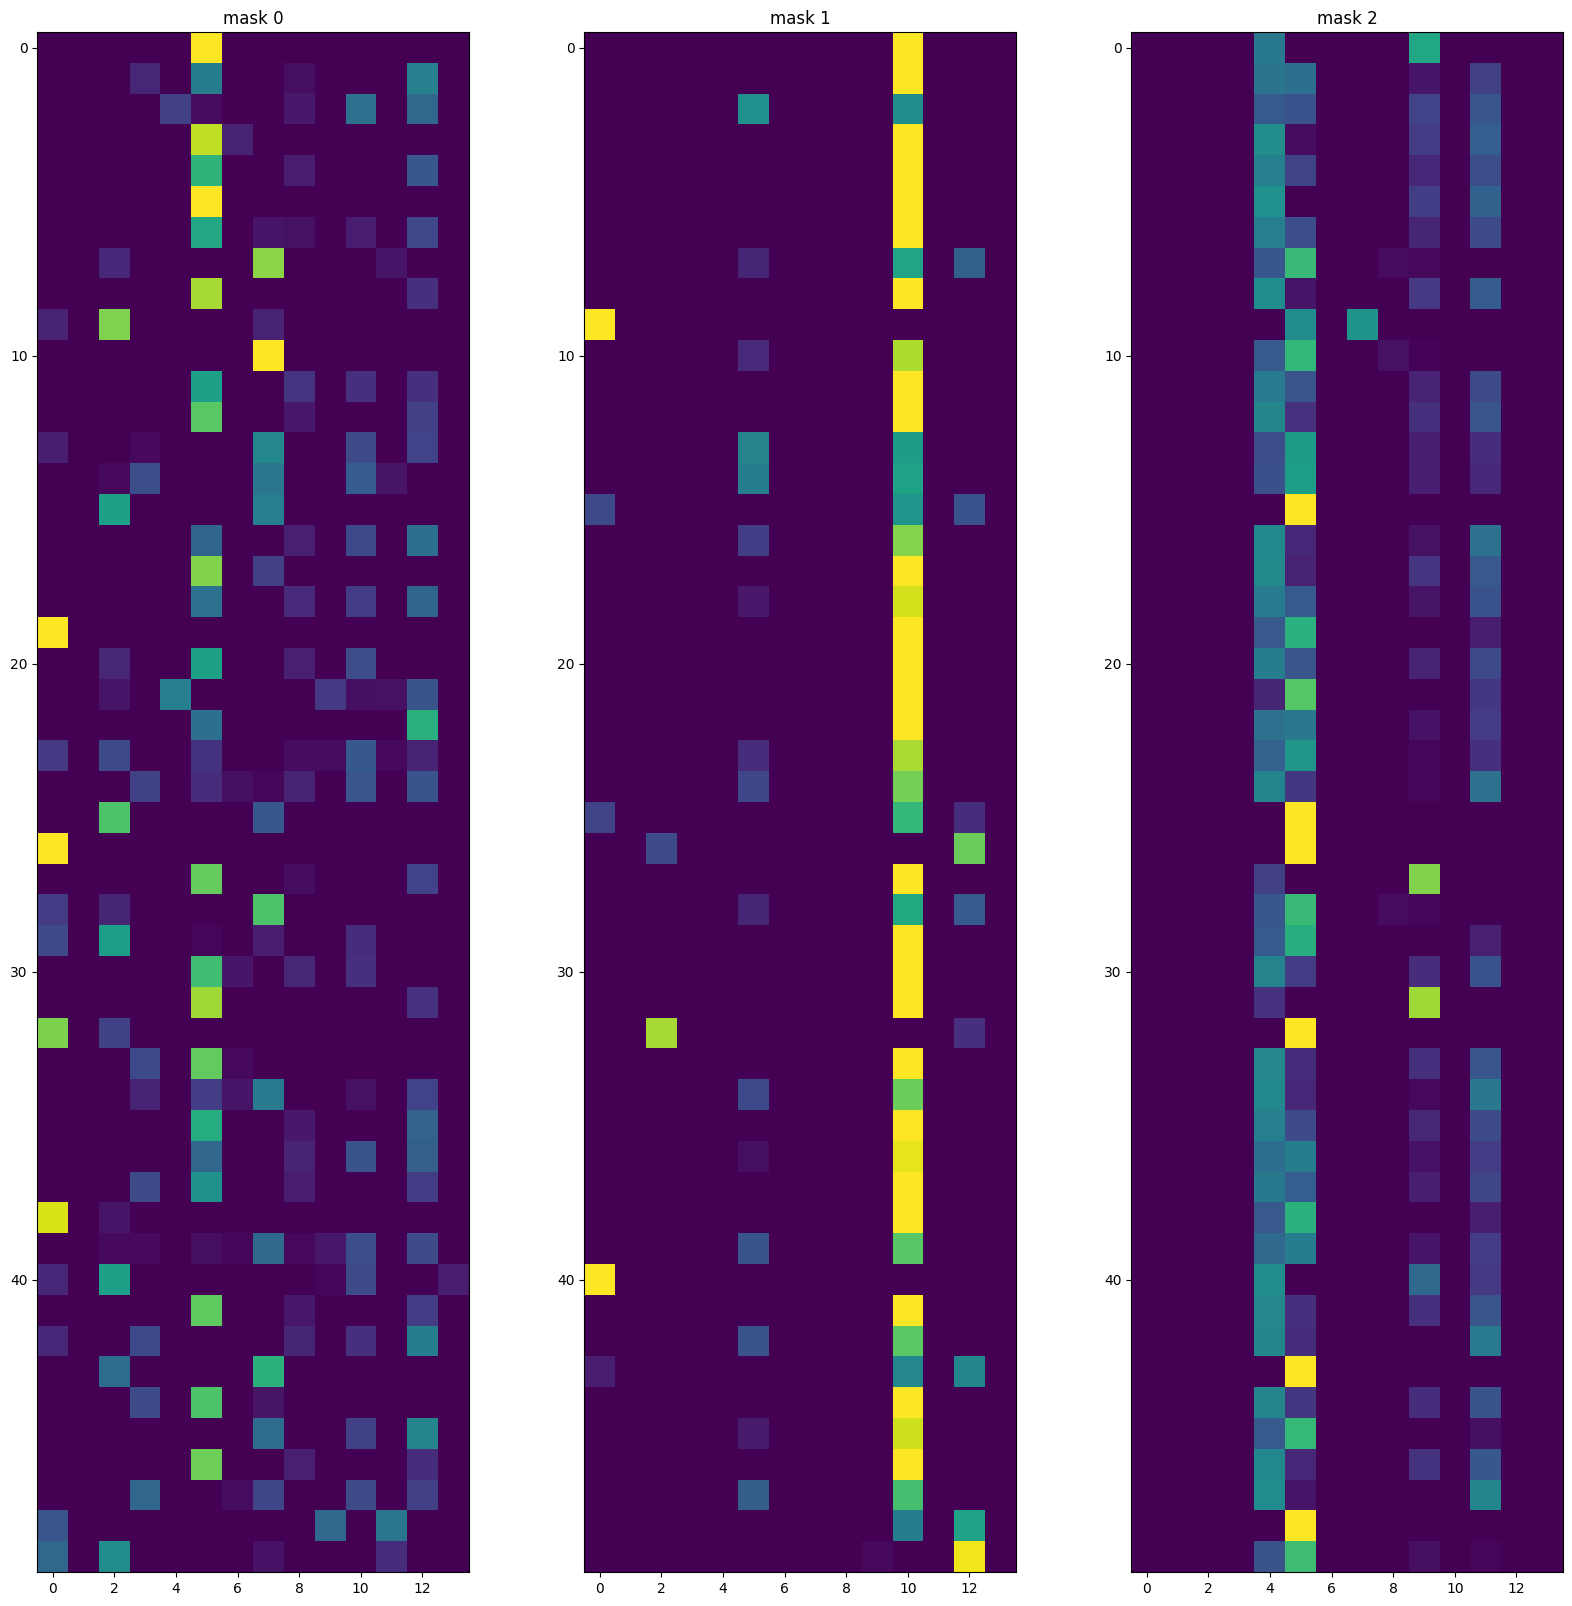

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.46966


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.33042
[20]	validation_0-rmse:0.30299
[30]	validation_0-rmse:0.29676
[40]	validation_0-rmse:0.29432
[50]	validation_0-rmse:0.29357
[60]	validation_0-rmse:0.29379
[70]	validation_0-rmse:0.29397
[80]	validation_0-rmse:0.29466
[89]	validation_0-rmse:0.29509


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, nthread=None, num_parallel_tree=None, ...)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.08611793607844748
0.09051238654361735
